In [ ]:
import pandas as pd
import networkx as nx
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import TransformerConv
from torch_geometric.nn import GATConv

from torch_geometric.nn import GCNConv
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.utils import from_networkx
from sklearn.metrics import confusion_matrix, classification_report
import os
from tqdm import tqdm
import joblib
import matplotlib.pyplot as plt
import glob
import time

from torch.nn import LSTM


import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc


In [3]:
import torch_geometric
torch_geometric.__version__


'2.5.3'

In [2]:
data_clean_folder = "stage3_data_cleaning/v2"
folder_path = data_clean_folder
xlsx_files = glob.glob(os.path.join(folder_path, '*.xlsx'))
xlsx_files

['stage3_data_cleaning/v2\\type10_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type1_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type2_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type3_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type4_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type5_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type6_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type7_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type8_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type9_label_merged_final_decoded_clean3.xlsx']

In [18]:
def calculate_optimized_pagerank(G, damping_factor=0.7):
    N = len(G)
    pagerank = {node: 1 / N for node in G}
    for _ in range(100):  # Iterate 100 times for convergence
        new_pagerank = {}
        for node in G:
            rank_sum = 0
            for neighbor in G.predecessors(node):
                weight_sum = sum([G[neighbor][succ]['weight'] for succ in G.successors(neighbor)])
                rank_sum += pagerank[neighbor] * (G[neighbor][node]['weight'] / weight_sum)
            new_pagerank[node] = (1 - damping_factor) / N + damping_factor * rank_sum
        pagerank = new_pagerank
    nx.set_node_attributes(G, pagerank, 'pagerank')
    return G

def create_graph_density(window_df, past_data):
    G = nx.DiGraph()
    index_tracker = {}
    
    for i in range(len(window_df) - 1):
        node1 = window_df.iloc[i]['can_id']
        node2 = window_df.iloc[i + 1]['can_id']
        timestamp_diff = window_df.iloc[i + 1]['timestamp'] - window_df.iloc[i]['timestamp']
        label = window_df.iloc[i]['label']
        transfer_id1 = window_df.iloc[i]['transfer_ID']
        transfer_id2 = window_df.iloc[i + 1]['transfer_ID']
        
        if node1 != node2 or transfer_id1 != transfer_id2:  # Allow self-loops only if transfer_IDs are different
            if G.has_edge(node1, node2):
                G[node1][node2]['weight'] += timestamp_diff
            else:
                G.add_edge(node1, node2, weight=timestamp_diff)
        
        # if node1 not in index_tracker:
        #     index_tracker[node1] = set()
        # index_tracker[node1].add((i, label))
        
        # if node2 not in index_tracker:
        #     index_tracker[node2] = set()
        # index_tracker[node2].add((i, label))

        
        if node1 not in index_tracker:
            index_tracker[node1] = []
        index_tracker[node1].append((i, label))
        
        
        if node2 not in index_tracker:
            index_tracker[node2] = []
        index_tracker[node2].append((i, label))

    
    # Convert sets to sorted lists to ensure consistent ordering
    index_tracker = {k: sorted(list(v)) for k, v in index_tracker.items()}
    
    # Calculate optimized PageRank
    G = calculate_optimized_pagerank(G)
    
    # Calculate density for each node based on past data
    density = calculate_density(window_df, past_data)
    
    for node in G.nodes:
        G.nodes[node]['density'] = density.get(node, 0.0)
    
    return G, index_tracker

def calculate_density(window_df, past_data):
    density = {}
    combined_data = pd.concat([past_data, window_df])
    for node in window_df['can_id'].unique():
        node_count = combined_data[combined_data['can_id'] == node].shape[0]
        density[node] = round(node_count / combined_data.shape[0],3)
    return density



def visualize_graph_density(G, window_index,visualization_dir):
    pos = nx.spring_layout(G)
    pagerank = nx.get_node_attributes(G, 'pagerank')
    density = nx.get_node_attributes(G, 'density')
    
    # Ensure all nodes have a pagerank value, set default if missing
    for node in G.nodes():
        if node not in pagerank:
            pagerank[node] = 0.0  # Default PageRank value
    
    labels = {node: f'{node}\nPR: {pagerank[node]:.2f}\nDensity: {density[node]}' for node in G.nodes()}
    
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, labels=labels, node_size=7000, node_color='skyblue', font_size=10, edge_color='gray')
    plt.title(f"Graph for Window {window_index}")
    output_path = os.path.join(visualization_dir, f'graph_window_with_density_{window_index}.png')
    plt.savefig(output_path)
    plt.close()


# def preprocess_data(data,output_dir,visualization_dir, window_size=100):
#     pyg_data_list = []
#     for window_start in tqdm(range(0, len(data), window_size)):
#         window_end = min(window_start + window_size, len(data))
#         window_data = data.iloc[window_start:window_end]
#         G, index_tracker = create_graph(window_data)
        
#         # Convert networkx graph to PyG data object
#         pyg_data = from_networkx(G, group_node_attrs=['pagerank'])
#         pyg_data.x = pyg_data.x.float()  # Ensure x is Float
        
        
#         # Add labels to PyG data object
#         labels = []
#         for node in G.nodes:
#             # Use the most recent label for each node
#             labels.append(index_tracker[node][-1][1])
#             G.nodes[node]['label'] = index_tracker[node][-1][1]
#         pyg_data.y = torch.tensor(labels, dtype=torch.long)
        
#         # Save the raw graph for later analysis
#         graph_path = os.path.join(output_dir, f'graph_window_{window_start // window_size}.graphml')
#         nx.write_graphml(G, graph_path)
        
#         # Save the visualization of the graph
#         visualize_graph(G, window_start // window_size,visualization_dir)
        
#         pyg_data_list.append(pyg_data)
    
#     return pyg_data_list


def preprocess_data_density(data,output_dir,visualization_dir,window_size=100, past_window_size=150):
    pyg_data_list = []
    past_data = pd.DataFrame()  # Initialize past data
    
    for window_start in tqdm(range(0, len(data), window_size)):
        window_end = min(window_start + window_size, len(data))
        window_data = data.iloc[window_start:window_end]
        
        # Create the graph with the current window and past data
        G, index_tracker = create_graph_density(window_data, past_data)
        
        # Convert networkx graph to PyG data object
        pyg_data = from_networkx(G, group_node_attrs=['pagerank', 'density'])
        pyg_data.x = pyg_data.x.float()  # Ensure x is Float
        
        # Assign labels as specified
        labels = []
        for node in G.nodes:
            # Use the most recent label for each node
            # labels.append(index_tracker[node][-1][1])
            label_count = sum(1 for idx, lbl in index_tracker[node] if lbl == 1)
            label_ratio = label_count / len(index_tracker[node])
            labels.append(round(label_ratio))
            G.nodes[node]['label'] = round(label_ratio)
        pyg_data.y = torch.tensor(labels, dtype=torch.long)

        
        # Save the raw graph for later analysis
        graph_path = os.path.join(output_dir, f'graph_window_{window_start // window_size}.graphml')
        nx.write_graphml(G, graph_path)
        
        # Save the visualization of the graph
        visualize_graph_density(G, window_start // window_size,visualization_dir)
        
        pyg_data_list.append(pyg_data)
        
        # Update past data for the next iteration
        past_data = pd.concat([past_data, window_data]).iloc[-past_window_size:]
    
    return pyg_data_list

# # Train the model


# Evaluate the model
# def evaluate_model(model, test_loader):
#     model.eval()
#     y_true = []
#     y_pred = []
#     for data in test_loader:
#         out = model(data.x, data.edge_index)
#         pred = out.argmax(dim=1)
#         y_true.extend(data.y.tolist())
#         y_pred.extend(pred.tolist())
    
#     cm = confusion_matrix(y_true, y_pred)
#     report = classification_report(y_true, y_pred)
#     return cm, report

# Save the model
# def save_model(model, path):
#     torch.save(model.state_dict(), path)


class EGraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(EGraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.lin(x)
        return F.log_softmax(x, dim=-1)



class EGraphGAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1):
        super(EGraphGAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads)
        self.lin = Linear(hidden_channels * heads, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.lin(x)
        return F.log_softmax(x, dim=-1)
    
class EGraphTransformer(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1):
        super(EGraphTransformer, self).__init__()
        self.conv1 = TransformerConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = TransformerConv(hidden_channels * heads, hidden_channels, heads=heads)
        self.lin = Linear(hidden_channels * heads, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.lin(x)
        return F.log_softmax(x, dim=-1)



class LSTMAggregator(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(LSTMAggregator, self).__init__()
        self.lstm = LSTM(in_channels, out_channels, batch_first=True)

    def forward(self, x, edge_index):
        # Assuming x is of shape [num_nodes, num_features]
        # Reshape x to [num_nodes, 1, num_features] for LSTM
        x = x.unsqueeze(1)
        x, (hn, cn) = self.lstm(x)
        # Flatten the output to [num_nodes, out_channels]
        x = x.squeeze(1)
        return x
    


class EGraphSAGE_with_LSTM(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(EGraphSAGE_with_LSTM, self).__init__()
        self.lstm_agg = LSTMAggregator(in_channels, hidden_channels)
        self.conv1 = SAGEConv(in_channels, hidden_channels, aggr=self.lstm_agg)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels, aggr=self.lstm_agg)
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.lin(x)
        return F.log_softmax(x, dim=-1)
    

class GCNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.lin(x)
        return F.log_softmax(x, dim=-1)

In [28]:

def visualize_graph_with_predictions(G, y_pred, window_index, visualization_dir):
    pos = nx.spring_layout(G)
    pagerank = nx.get_node_attributes(G, 'pagerank')
    density = nx.get_node_attributes(G, 'density')

    
    visualization_dir_pred =  os.path.join(visualization_dir, "test_set_pred")
    
    # Color nodes based on prediction
    color_map = ['red' if pred == 1 else 'blue' for pred in y_pred]
    
    labels = {node: f'{node}\nPR: {pagerank[node]:.2f}\nDensity: {density[node]}' for node in G.nodes()}
    
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, labels=labels, node_size=7000, node_color=color_map, font_size=10, edge_color='gray')
    plt.title(f"Graph for Window {window_index}")
    output_path = os.path.join(visualization_dir_pred, f'graph_with_predictions_window_{window_index}.png')
    plt.savefig(output_path)
    plt.close()

def plot_roc_curve(y_true, y_prob, title,result_dir):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {title}')
    plt.legend(loc='lower right')
    plt.savefig(f'{result_dir}/roc_curve_{title}.png')
    plt.show()

# def plot_roc_curve(y_true, y_prob, title):
#     fpr, tpr, _ = roc_curve(y_true, y_prob)
#     roc_auc = auc(fpr, tpr)
    
#     plt.figure(figsize=(10, 6))
#     plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
#     plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title(f'Receiver Operating Characteristic - {title}')
#     plt.legend(loc='lower right')
#     plt.show()

def train_model(model, train_loader, optimizer, criterion,title,result_dir, epochs=50):
    model.train()
    loss_values = []

    best_loss = float('inf')
    best_model_state = None

    for epoch in range(epochs):
        total_loss = 0
        for data in train_loader:
            optimizer.zero_grad()
            out = model(data.x, data.edge_index)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        loss_values.append(avg_loss)
        print(f'Epoch {epoch + 1}, Loss: {avg_loss}')

        # Save the best model based on the lowest loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model_state = model.state_dict()
    
    # Plot training loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), loss_values, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training Loss over Epochs {title}')
    plt.legend()
    plt.savefig(f'{result_dir}/traing_loss_over_epochs_{title}.png')
    plt.show()

    return best_model_state

from sklearn.exceptions import UndefinedMetricWarning
import warnings

def pyg_data_to_pandas(data):
    node_attributes = data.x.numpy()  # Assuming node attributes are stored in data.x
    edge_index = data.edge_index.numpy()
    edge_attributes = data.edge_attr.numpy() if data.edge_attr is not None else None
    
    # Create DataFrame for node attributes
    node_df = pd.DataFrame(node_attributes, columns=[f'node_feature_{i}' for i in range(node_attributes.shape[1])])
    node_df['node_id'] = range(node_attributes.shape[0])
    
    # Create DataFrame for edge attributes if they exist
    if edge_attributes is not None:
        edge_df = pd.DataFrame(edge_attributes, columns=[f'edge_feature_{i}' for i in range(edge_attributes.shape[1])])
        edge_df['source'] = edge_index[0, :]
        edge_df['target'] = edge_index[1, :]
    else:
        edge_df = pd.DataFrame(edge_index.T, columns=['source', 'target'])
    
    return node_df, edge_df

def evaluate_model(model, test_loader, title,result_dir, visualization_dir):
    model.eval()
    y_true = []
    y_pred = []
    y_prob = []
    for data in test_loader:
        out = model(data.x, data.edge_index)
        prob = out.softmax(dim=1)[:, 1]  # Get probability of class 1
        pred = out.argmax(dim=1)
        y_true.extend(data.y.tolist())
        y_pred.extend(pred.tolist())
        y_prob.extend(prob.tolist())

    # Handle undefined metrics warning
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UndefinedMetricWarning)
        report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    
    
    cm = confusion_matrix(y_true, y_pred)
    # report = classification_report(y_true, y_pred,output_dict=True)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {title}')
    plt.savefig(f'{result_dir}/confusion_matrix_{title}.png')
    plt.show()
    
    # Plot ROC curve
    plot_roc_curve(y_true, y_prob, title,result_dir)

    # # Visualize the graph with predictions
    # for window_index, data in enumerate(test_loader):
    #     G, _ = create_graph_density(data.to_pandas(),pd.DataFrame())
    #     visualize_graph_with_predictions(G, y_pred[window_index * len(data.y):(window_index + 1) * len(data.y)], window_index, result_dir, visualization_dir)
    
    
    return cm, report


# def evaluate_model(model, test_loader, title, result_dir, visualization_dir, window_size=100, past_window_size=150):
#     model.eval()
#     y_true = []
#     y_pred = []
#     y_prob = []
#     past_data = pd.DataFrame()  # Initialize past data
    
#     # Iterate over test data
#     for window_index, data in enumerate(test_loader):
#         with torch.no_grad():
#             out = model(data.x, data.edge_index)
#             prob = out.softmax(dim=1)[:, 1]  # Get probability of class 1
#             pred = out.argmax(dim=1)
            
#             y_true.extend(data.y.tolist())
#             y_pred.extend(pred.tolist())
#             y_prob.extend(prob.tolist())
        
#         # Convert PyG data to pandas DataFrame to simulate past data handling
#         node_df, edge_df = pyg_data_to_pandas(data)
        
#         # Assuming the node_df has a 'label' column, you can create window_data
#         window_data = node_df
#         window_data['label'] = data.y.numpy()  # Assuming you have a label attribute in data
#         window_data['timestamp'] = data.timestamp.numpy()  # Assuming you have a timestamp attribute
        
#         # Create the graph with the current window and past data
#         G, index_tracker = create_graph_density(window_data, past_data)
        
#         # Save the visualization of the graph with predictions
#         visualize_graph_with_predictions(G, y_pred[window_index * len(data.y):(window_index + 1) * len(data.y)], window_index, visualization_dir)
        
#         # Update past data for the next iteration
#         past_data = pd.concat([past_data, window_data]).iloc[-past_window_size:]
    
#     # Check lengths match expected test size
#     print(f"Number of true labels: {len(y_true)}")
#     print(f"Number of predicted labels: {len(y_pred)}")
    
#     cm = confusion_matrix(y_true, y_pred)
    
#     # Handle undefined metrics warning
#     with warnings.catch_warnings():
#         warnings.simplefilter("ignore", UndefinedMetricWarning)
#         report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    
#     # Plot confusion matrix
#     plt.figure(figsize=(10, 6))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.title(f'Confusion Matrix - {title}')
#     plt.savefig(f'{result_dir}/confusion_matrix_{title}.png')
#     plt.show()
    
#     # Plot ROC curve
#     plot_roc_curve(y_true, y_prob, title, result_dir)
    
#     return cm, report

# def evaluate_model(model, test_loader, title, result_dir, visualization_dir, window_size=100, past_window_size=150):
#     model.eval()
#     y_true = []
#     y_pred = []
#     y_prob = []
#     past_data = pd.DataFrame()  # Initialize past data
    
#     # Iterate over test data
#     for window_index, data in enumerate(test_loader):
#         with torch.no_grad():
#             out = model(data.x, data.edge_index)
#             prob = out.softmax(dim=1)[:, 1]  # Get probability of class 1
#             pred = out.argmax(dim=1)
            
#             y_true.extend(data.y.tolist())
#             y_pred.extend(pred.tolist())
#             y_prob.extend(prob.tolist())
        
#         # Convert the test_loader data back to a pandas DataFrame to simulate past data handling
#         window_data = data.to_pandas()  # Assuming this method exists or you have a way to convert Data to pandas
        
#         # Create the graph with the current window and past data
#         G, index_tracker = create_graph_density(window_data, past_data)
        
#         # Save the visualization of the graph with predictions
#         visualize_graph_with_predictions(G, y_pred[window_index * len(data.y):(window_index + 1) * len(data.y)], window_index, visualization_dir)
        
#         # Update past data for the next iteration
#         past_data = pd.concat([past_data, window_data]).iloc[-past_window_size:]
    
#     # Check lengths match expected test size
#     print(f"Number of true labels: {len(y_true)}")
#     print(f"Number of predicted labels: {len(y_pred)}")
    
#     cm = confusion_matrix(y_true, y_pred)
    
#     # Handle undefined metrics warning
#     with warnings.catch_warnings():
#         warnings.simplefilter("ignore", UndefinedMetricWarning)
#         report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    
#     # Plot confusion matrix
#     plt.figure(figsize=(10, 6))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.title(f'Confusion Matrix - {title}')
#     plt.savefig(f'{result_dir}/confusion_matrix_{title}.png')
#     plt.show()
    
#     # Plot ROC curve
#     plot_roc_curve(y_true, y_prob, title, result_dir)
    
#     return cm, report
# Save the model
def save_model(model, path):
    torch.save(model.state_dict(), path)

from collections import Counter
import torch.nn.functional as F

def train_model_with_class_weights(model, train_loader, optimizer, criterion, title, result_dir, epochs=50):
    model.train()
    loss_values = []
    best_loss = float('inf')
    best_model_state = None
    print("Inside train model with class weights")
    
    # Calculate class weights
    labels = [data.y.tolist() for data in train_loader]
    labels = [item for sublist in labels for item in sublist]  # Flatten the list
    class_counts = Counter(labels)
    total_count = sum(class_counts.values())
    class_weights = {cls: total_count/count for cls, count in class_counts.items()}
    weights = torch.tensor([class_weights[cls] for cls in sorted(class_weights.keys())]).float()
    criterion = torch.nn.CrossEntropyLoss(weight=weights)
    
    for epoch in range(epochs):
        total_loss = 0
        for data in train_loader:
            optimizer.zero_grad()
            out = model(data.x, data.edge_index)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        loss_values.append(avg_loss)
        print(f'Epoch {epoch + 1}, Loss: {avg_loss}')

        # Save the best model based on the lowest loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model_state = model.state_dict()

    # Plot training loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), loss_values, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training Loss over Epochs {title}')
    plt.legend()
    plt.savefig(f'{result_dir}/training_loss_over_epochs_{title}.png')
    plt.show()

    return best_model_state

In [20]:

def load_saved_graphs(graph_dir):
    pyg_data_list = []
    for graph_file in sorted(os.listdir(graph_dir)):
        if graph_file.endswith('.graphml'):
            graph_path = os.path.join(graph_dir, graph_file)
            G = nx.read_graphml(graph_path)
            
            # Convert networkx graph to PyG data object
            pyg_data = from_networkx(G, group_node_attrs=['pagerank'])
            pyg_data.x = pyg_data.x.float()  # Ensure x is Float
            
            # Assuming labels are stored in the graph attributes
            labels = [G.nodes[node]['label'] for node in G.nodes]
            pyg_data.y = torch.tensor(labels, dtype=torch.long)
            
            pyg_data_list.append(pyg_data)
    
    return pyg_data_list

In [29]:
def run_GCnn(train_loader,test_loader,title,result_dir,visualization_dir):

    model = GCNN(in_channels=2, hidden_channels=128, out_channels=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    model_dir =  os.path.join(result_dir, "saved_models")
    title_dir = os.path.join(result_dir, title)
    classification_report_dir = os.path.join(result_dir, "classification_report")
    os.makedirs(title_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(classification_report_dir, exist_ok=True)

    # best_model_state = train_model(model, train_loader, optimizer, criterion,title,title_dir)
    best_model_state = train_model_with_class_weights(model, train_loader, optimizer, criterion,title,title_dir)
    
    # Load the best model state
    model.load_state_dict(best_model_state)
    cm, report = evaluate_model(model, test_loader,title,title_dir,visualization_dir)


    report_df = pd.DataFrame(report).transpose()
    time_str = str(time.time()).replace('.','_')
    report_df.to_csv(f'{classification_report_dir}/classification_report_{title}_{time_str}.csv', index=True)
    

    save_model(model, os.path.join(model_dir, f'graph_{title}_model.pth'))
    return cm,report,report['accuracy']

def run_SageConv_lstm(train_loader,test_loader,title,result_dir,visualization_dir):

    model = EGraphSAGE_with_LSTM(in_channels=2, hidden_channels=128, out_channels=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    model_dir =  os.path.join(result_dir, "saved_models")
    title_dir = os.path.join(result_dir, title)
    classification_report_dir = os.path.join(result_dir, "classification_report")
    os.makedirs(title_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(classification_report_dir, exist_ok=True)

    # train_model(model, train_loader, optimizer, criterion,title,title_dir)
    # best_model_state = train_model(model, train_loader, optimizer, criterion,title,title_dir)
    best_model_state = train_model_with_class_weights(model, train_loader, optimizer, criterion,title,title_dir)
    
    # Load the best model state
    model.load_state_dict(best_model_state)
    cm, report = evaluate_model(model, test_loader,title,title_dir,visualization_dir)


    report_df = pd.DataFrame(report).transpose()
    time_str = str(time.time()).replace('.','_')
    report_df.to_csv(f'{classification_report_dir}/classification_report_{title}_{time_str}.csv', index=True)
    

    save_model(model, os.path.join(model_dir, f'graph_{title}_model.pth'))
    return cm,report,report['accuracy']

def run_SageConv(train_loader,test_loader,title,result_dir,visualization_dir):
    # title = "SageConv"
    model = EGraphSAGE(in_channels=2, hidden_channels=128, out_channels=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    model_dir =  os.path.join(result_dir, "saved_models")
    title_dir = os.path.join(result_dir, title)
    classification_report_dir = os.path.join(result_dir, "classification_report")
    os.makedirs(title_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(classification_report_dir, exist_ok=True)

    # train_model(model, train_loader, optimizer, criterion,title,title_dir)
    # best_model_state = train_model(model, train_loader, optimizer, criterion,title,title_dir)
    best_model_state = train_model_with_class_weights(model, train_loader, optimizer, criterion,title,title_dir)
    
    # Load the best model state
    model.load_state_dict(best_model_state)
    cm, report = evaluate_model(model, test_loader,title,title_dir,visualization_dir)


    
    report_df = pd.DataFrame(report).transpose()
    time_str = str(time.time()).replace('.','_')
    report_df.to_csv(f'{classification_report_dir}/classification_report_{title}_{time_str}.csv', index=True)

    save_model(model, os.path.join(model_dir, f'graph_{title}_model.pth'))
    return cm,report,report['accuracy']

def run_GAT(train_loader,test_loader,title,result_dir,visualization_dir):
    model = EGraphGAT(in_channels=2, hidden_channels=128, out_channels=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    model_dir =  os.path.join(result_dir, "saved_models")
    title_dir = os.path.join(result_dir, title)
    classification_report_dir = os.path.join(result_dir, "classification_report")
    os.makedirs(title_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(classification_report_dir, exist_ok=True)

    # train_model(model, train_loader, optimizer, criterion,title,title_dir)
    # best_model_state = train_model(model, train_loader, optimizer, criterion,title,title_dir)
    best_model_state = train_model_with_class_weights(model, train_loader, optimizer, criterion,title,title_dir)
    
    # Load the best model state
    model.load_state_dict(best_model_state)
    cm, report = evaluate_model(model, test_loader,title,title_dir,visualization_dir)


    
    report_df = pd.DataFrame(report).transpose()
    time_str = str(time.time()).replace('.','_')
    report_df.to_csv(f'{classification_report_dir}/classification_report_{title}_{time_str}.csv', index=True)

    save_model(model, os.path.join(model_dir, f'graph_{title}_model.pth'))
    return cm,report,report['accuracy']

def run_GTransformer(train_loader,test_loader,title,result_dir,visualization_dir):
    model = EGraphTransformer(in_channels=2, hidden_channels=128, out_channels=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    model_dir =  os.path.join(result_dir, "saved_models")
    title_dir = os.path.join(result_dir, title)
    classification_report_dir = os.path.join(result_dir, "classification_report")
    os.makedirs(title_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(classification_report_dir, exist_ok=True)

    # train_model(model, train_loader, optimizer, criterion,title,title_dir)
    # best_model_state = train_model(model, train_loader, optimizer, criterion,title,title_dir)
    best_model_state = train_model_with_class_weights(model, train_loader, optimizer, criterion,title,title_dir)
    
    # Load the best model state
    model.load_state_dict(best_model_state)
    cm, report = evaluate_model(model, test_loader,title,title_dir,visualization_dir)

    

    report_df = pd.DataFrame(report).transpose()
    time_str = str(time.time()).replace('.','_')
    report_df.to_csv(f'{classification_report_dir}/classification_report_{title}_{time_str}.csv', index=True)
    

    save_model(model, os.path.join(model_dir, f'graph_{title}_model.pth'))
    return cm,report,report['accuracy']

In [30]:
import time
int(time.time()),str(time.time()).replace('.','_')

(1721137765, '1721137765_8990877')

In [31]:
# new_execution_flag = input("Do u want new execution")
# new_execution_flag
def assign_value():
    user_input = input("Please enter '1' or '0': ").strip().lower()
    
    if user_input == '1':
        return 1
    elif user_input == '0':
        return 0
    else:
        print("Invalid input. Please enter '1' or '0'.")
        return assign_value()
    
# assigned_value = assign_value()

type10_label


100%|██████████| 2074/2074 [09:26<00:00,  3.66it/s]
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


train_data: 1451
test_data: 623
train_data:1451
test_data:623
Inside train model with class weights
Epoch 1, Loss: 0.36558263975641003
Epoch 2, Loss: 0.2515127986021664
Epoch 3, Loss: 0.24481859608836795
Epoch 4, Loss: 0.232919591276542
Epoch 5, Loss: 0.23557201060264008
Epoch 6, Loss: 0.2210939066565555
Epoch 7, Loss: 0.22669898394657217
Epoch 8, Loss: 0.2190471466468728
Epoch 9, Loss: 0.21037078713593277
Epoch 10, Loss: 0.21229339488174603
Epoch 11, Loss: 0.2183457120605137
Epoch 12, Loss: 0.21917943753626035
Epoch 13, Loss: 0.21086827017690823
Epoch 14, Loss: 0.2101236759968426
Epoch 15, Loss: 0.19767881605936133
Epoch 16, Loss: 0.20161971903365591
Epoch 17, Loss: 0.2079021621333516
Epoch 18, Loss: 0.20387469912352768
Epoch 19, Loss: 0.20373991747265277
Epoch 20, Loss: 0.1991697504468586
Epoch 21, Loss: 0.20409255960713263
Epoch 22, Loss: 0.20187046848561452
Epoch 23, Loss: 0.1919913581855919
Epoch 24, Loss: 0.19957071915268898
Epoch 25, Loss: 0.1875424378592035
Epoch 26, Loss: 0.19

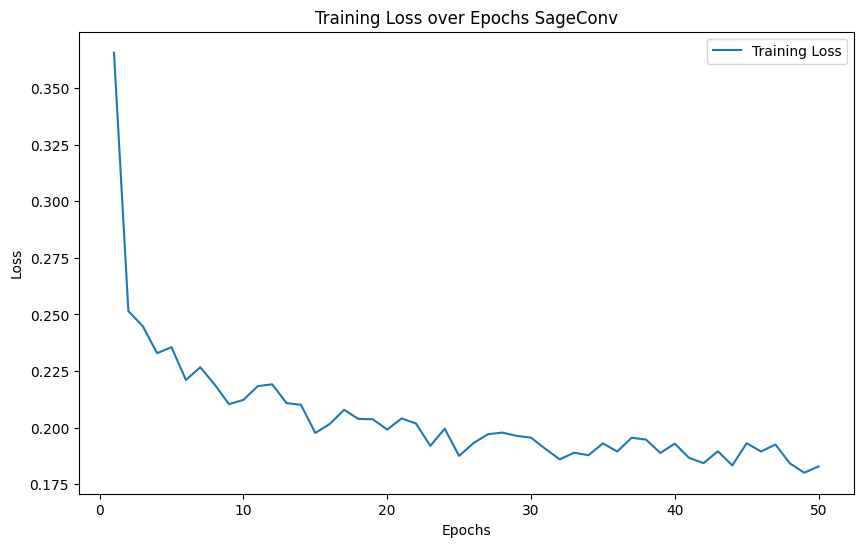

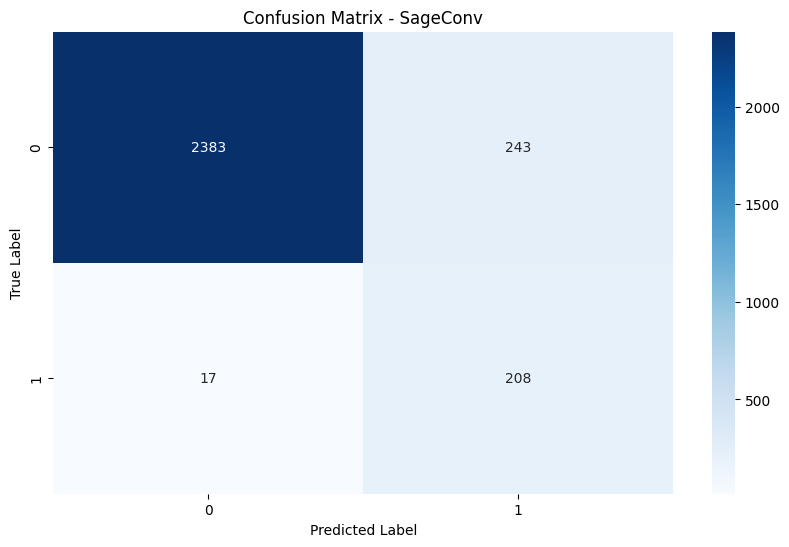

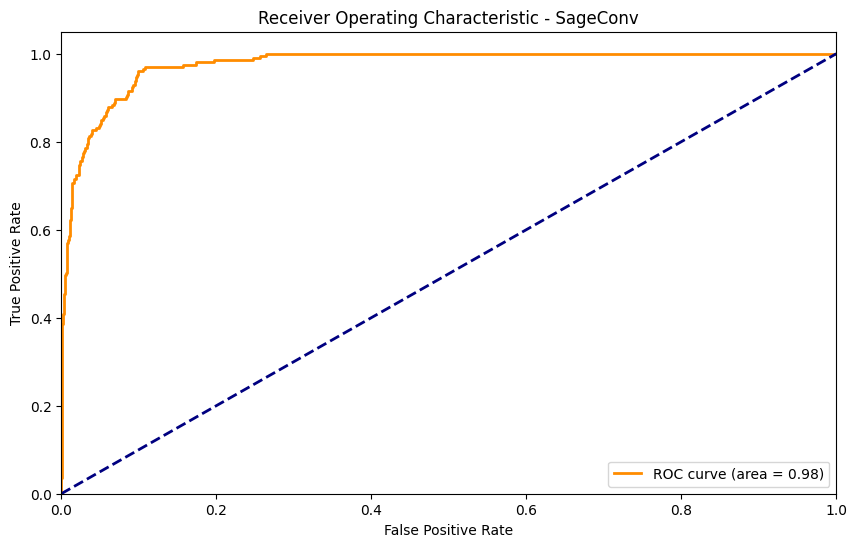

Inside train model with class weights
Epoch 1, Loss: 0.624906318343204
Epoch 2, Loss: 0.5001401039569274
Epoch 3, Loss: 0.446764825478844
Epoch 4, Loss: 0.435830083878144
Epoch 5, Loss: 0.428841518967048
Epoch 6, Loss: 0.38468072271865345
Epoch 7, Loss: 0.3513610508778821
Epoch 8, Loss: 0.3425687671355579
Epoch 9, Loss: 0.331562307541785
Epoch 10, Loss: 0.32373923192853515
Epoch 11, Loss: 0.3159702582203824
Epoch 12, Loss: 0.3154563307762146
Epoch 13, Loss: 0.31562797887169797
Epoch 14, Loss: 0.3129516567872918
Epoch 15, Loss: 0.31007240064766095
Epoch 16, Loss: 0.30904720367296884
Epoch 17, Loss: 0.3078306197472241
Epoch 18, Loss: 0.30327652135620947
Epoch 19, Loss: 0.30764946892209677
Epoch 20, Loss: 0.29877310926499573
Epoch 21, Loss: 0.30176612313674844
Epoch 22, Loss: 0.29546253933854727
Epoch 23, Loss: 0.3023305810664011
Epoch 24, Loss: 0.29905893750812695
Epoch 25, Loss: 0.29837658450655313
Epoch 26, Loss: 0.293927742411261
Epoch 27, Loss: 0.29131108684384305
Epoch 28, Loss: 0.2

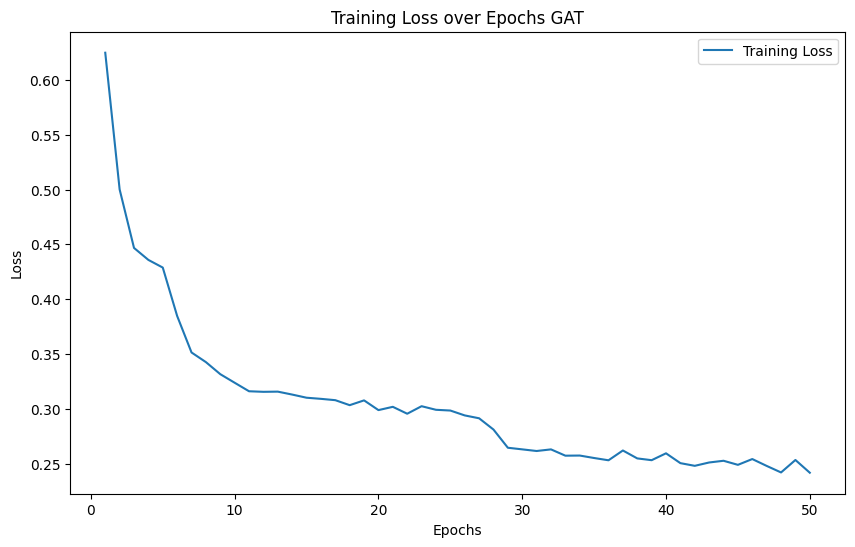

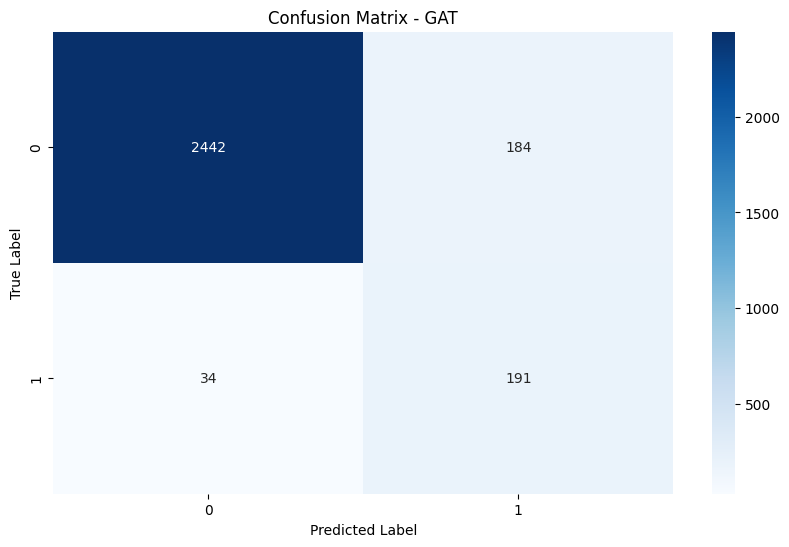

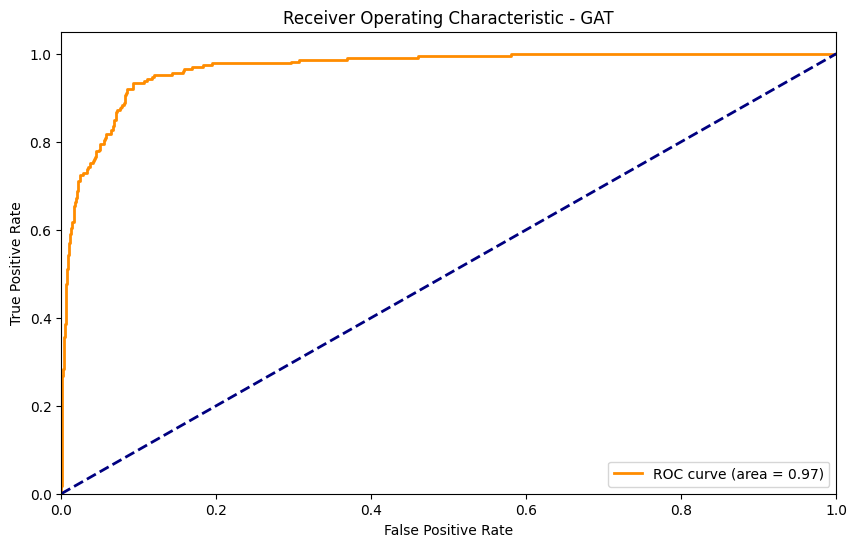

Inside train model with class weights
Epoch 1, Loss: 0.37331698478563974
Epoch 2, Loss: 0.26271660107633343
Epoch 3, Loss: 0.24836544757303985
Epoch 4, Loss: 0.2416275882202646
Epoch 5, Loss: 0.2308283409346705
Epoch 6, Loss: 0.2355985741900361
Epoch 7, Loss: 0.23022835021433624
Epoch 8, Loss: 0.22318544076836627
Epoch 9, Loss: 0.22539969404106555
Epoch 10, Loss: 0.22378682086001273
Epoch 11, Loss: 0.21741783926668373
Epoch 12, Loss: 0.21236785209697226
Epoch 13, Loss: 0.22032663517672083
Epoch 14, Loss: 0.2135584176234577
Epoch 15, Loss: 0.20605263275944669
Epoch 16, Loss: 0.20714844568915988
Epoch 17, Loss: 0.20261538822365843
Epoch 18, Loss: 0.20322376230488653
Epoch 19, Loss: 0.20807706920996957
Epoch 20, Loss: 0.1950147882427858
Epoch 21, Loss: 0.20192283505330916
Epoch 22, Loss: 0.20025590564245763
Epoch 23, Loss: 0.20234827162778896
Epoch 24, Loss: 0.18727108026328293
Epoch 25, Loss: 0.1956863121494003
Epoch 26, Loss: 0.20210467764864798
Epoch 27, Loss: 0.19052850066319757
Epoch

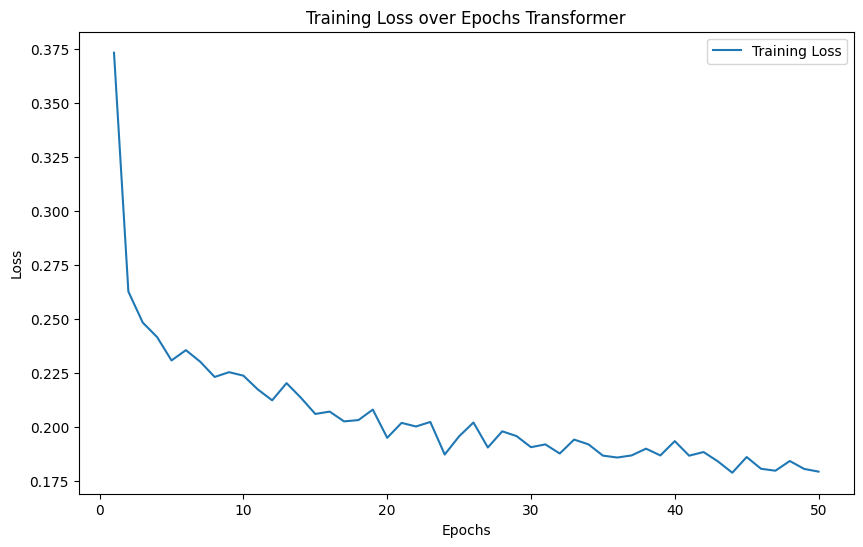

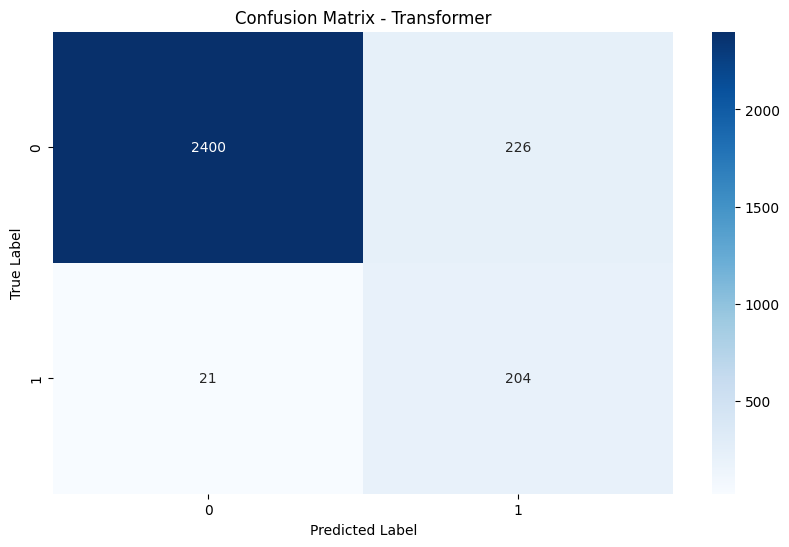

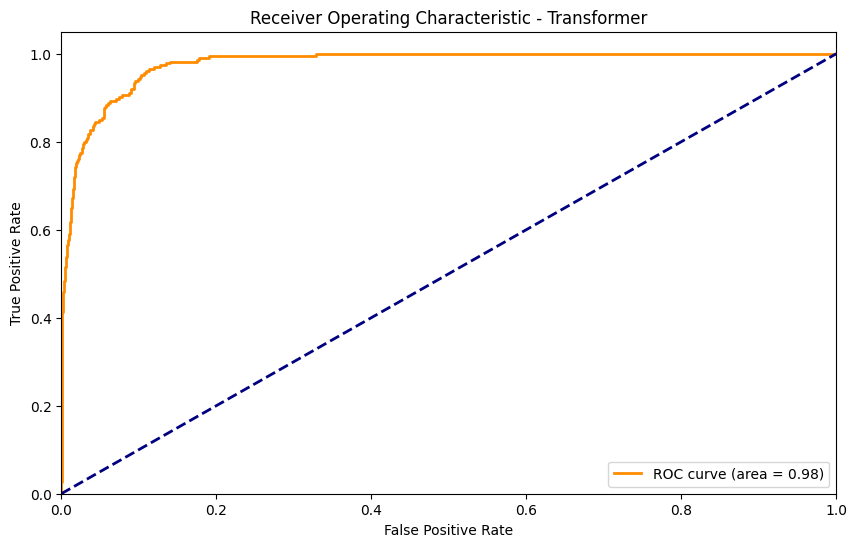

AttributeError: 'SAGEConv' object has no attribute 'aggr'

In [37]:
import random
from torch.utils.data import random_split


new_execution_flag = 1
# assign_value()
if new_execution_flag == 1:
    current_time = time.localtime()
    folder_name = time.strftime("%Y-%m-%d_%H-%M-%S", current_time)
else:
    folder_name = input("Input folder name from all_execution_data")

result_dict = {}
for file_path in xlsx_files:
    

    if new_execution_flag == 1:
        data = pd.read_excel(file_path)
        data['can_id'] = data['can_id'].astype(str)
    
    label_key = os.path.basename(file_path).split('.')[0][0:12]
    print(label_key)

    output_dir = f"all_execution_data/{folder_name}/{label_key}/graphs"
    visualization_dir = os.path.join(f"all_execution_data/{folder_name}/{label_key}", "visualizations")
    result_dir =  os.path.join(f"all_execution_data/{folder_name}/{label_key}", "results")

    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(visualization_dir, exist_ok=True)
    os.makedirs(result_dir, exist_ok=True)
    
    if new_execution_flag == 1:
        pyg_data_list = preprocess_data_density(data,output_dir,visualization_dir)
    else:
        pyg_data_list = load_saved_graphs(output_dir)

    train_size = int(0.7 * len(pyg_data_list))
    test_size = len(pyg_data_list) - train_size
    train_data, test_data = random_split(pyg_data_list, [train_size, test_size])

    print(f"train_data: {len(train_data)}\ntest_data: {len(test_data)}")


    # train_size = int(0.7 * len(pyg_data_list))
    # train_data = pyg_data_list[:train_size]
    # test_data = pyg_data_list[train_size:]

    # # Assuming pyg_graphs is your dataset and you have split it into train and test
    # train_size = int(0.8 * len(pyg_graphs))
    # test_size = len(pyg_graphs) - train_size
    # train_dataset, test_dataset = torch.utils.data.random_split(pyg_graphs, [train_size, test_size])


    print(f"train_data:{len(train_data)}\ntest_data:{len(test_data)}")

    train_loader = DataLoader(train_data, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

    _,_,acc = run_SageConv(train_loader,test_loader,'SageConv',result_dir,visualization_dir)
    _,_,gat_acc = run_GAT(train_loader,test_loader,'GAT',result_dir,visualization_dir)
    _,_,transformer_acc = run_GTransformer(train_loader,test_loader,'Transformer',result_dir,visualization_dir)
    _,_,sageConv_lstm_acc =run_SageConv_lstm(train_loader,test_loader,'sageConv_lstm',result_dir,visualization_dir)
    _,_,gcnn_acc =run_GCnn(train_loader,test_loader,'gcnn',result_dir,visualization_dir)

    result_dict[label_key] = {
        'GSageConv': acc,
        'GAT': gat_acc,
        'GTransformer': transformer_acc,
        'GSage_conv_lstm': sageConv_lstm_acc,
        'GCNN': gcnn_acc
    }

    print(result_dict)



# Create DataFrame
results_df = pd.DataFrame.from_dict(result_dict, orient='index')

# Save the DataFrame to a CSV file
time_str = str(time.time()).replace('.','_')
results_df.to_csv(f"all_execution_data/{folder_name}/results_analysis_{time_str}.csv")



In [ ]:
# result_dict

{'type10_label': {'GSageConv': 0.9077139837971117,
  'GAT': 0.8569918985558295,
  'GTransformer': 0.9115885875308207,
  'GCNN': 0.8555829517435717},
 'type1_label_': {'GSageConv': 0.9916617033948779,
  'GAT': 0.8862418106015485,
  'GTransformer': 0.9910661107802263,
  'GCNN': 0.8761167361524718},
 'type2_label_': {'GSageConv': 0.98545101842871,
  'GAT': 0.9835111542192047,
  'GTransformer': 0.9936954413191077,
  'GCNN': 0.989815712900097},
 'type3_label_': {'GSageConv': 0.9877222692633362,
  'GAT': 0.8289585097375106,
  'GTransformer': 0.9872988992379339,
  'GCNN': 0.8585944115156647},
 'type4_label_': {'GSageConv': 0.9961190168175937,
  'GAT': 0.9905131522207848,
  'GTransformer': 0.9952565761103924,
  'GCNN': 0.9909443725743855},
 'type5_label_': {'GSageConv': 0.8458265139116203,
  'GAT': 0.8497545008183306,
  'GTransformer': 0.8661211129296236,
  'GCNN': 0.8710310965630115},
 'type6_label_': {'GSageConv': 0.9190408357075024,
  'GAT': 0.7934472934472935,
  'GTransformer': 0.938271604

In [ ]:
results_df

,GSageConv,GAT,GTransformer,GCNN
type10_label,0.907714,0.856992,0.911589,0.855583
type1_label_,0.991662,0.886242,0.991066,0.876117
type2_label_,0.985451,0.983511,0.993695,0.989816
type3_label_,0.987722,0.828959,0.987299,0.858594
type4_label_,0.996119,0.990513,0.995257,0.990944
type5_label_,0.845827,0.849755,0.866121,0.871031
type6_label_,0.919041,0.793447,0.938272,0.880579
type7_label_,0.909677,0.762988,0.905263,0.848557
type8_label_,0.933549,0.916495,0.935019,0.889444
type9_label_,0.802011,0.697414,0.810920,0.772989


In [ ]:

# Create DataFrame
results_df = pd.DataFrame.from_dict(result_dict, orient='index')

# Save the DataFrame to a CSV file
time_str = str(time.time()).replace('.','_')
results_df.to_csv(f"all_execution_data/{folder_name}/results_analysis_{time_str}.csv")

In [ ]:
results_df